cuda:0
{'fir': 0, 'pine': 1, 'spruce': 2, 'trembling aspen': 3}


100%|██████████| 67/67 [00:01<00:00, 48.09it/s]


[[54.  9. 10.  2.]
 [ 2. 39.  1.  4.]
 [22.  7. 69.  7.]
 [ 0.  0.  0. 42.]]


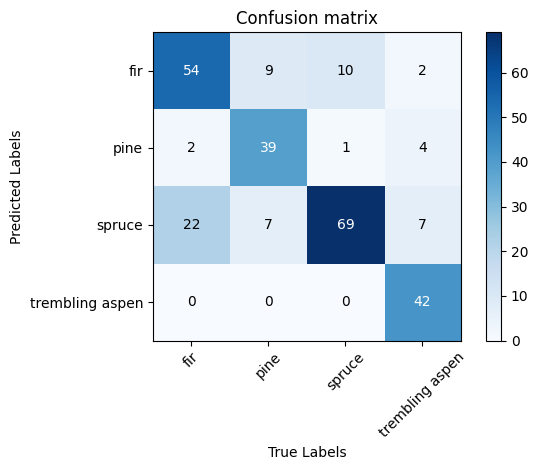

the model accuracy is  0.7611940298507462
User’s Accuracy is: 0.692
Producer’s Accuracy is: 0.72
Expected Accuracy is: 0.592
Kappa Statistic is: 0.414691249634182
User’s Accuracy is: 0.709
Producer’s Accuracy is: 0.848
Expected Accuracy is: 0.694
Kappa Statistic is: 0.21958833284557608
User’s Accuracy is: 0.862
Producer’s Accuracy is: 0.657
Expected Accuracy is: 0.544
Kappa Statistic is: 0.47630269704111017
User’s Accuracy is: 0.764
Producer’s Accuracy is: 1.0
Expected Accuracy is: 0.702
Kappa Statistic is: 0.19863768406290697
+-----------------+-----------+--------+-------------+
|                 | Precision | Recall | Specificity |
+-----------------+-----------+--------+-------------+
|       fir       |    0.72   | 0.692  |    0.889    |
|       pine      |   0.848   | 0.709  |    0.967    |
|      spruce     |   0.657   | 0.862  |    0.809    |
| trembling aspen |    1.0    | 0.764  |     1.0     |
+-----------------+-----------+--------+-------------+


In [1]:
import os
import json

import torch
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader

class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            UA = round(TP / (TP + FN),3) if TP + FN != 0 else 0.
            PA = round(TP / (TP + FP),3) if TP + FP != 0 else 0.
            EA = round(((TP+FP)*(TP+FN)+(TN+FP)*(TN+FN))/(TP+TN+FP+FN)**2,3) if TP+TN+FP+FN != 0 else 0.
            Kappa = (acc-EA)/(1-EA)
            print('User’s Accuracy is:',UA)
            print('Producer’s Accuracy is:',PA)
            print('Expected Accuracy is:',EA)
            print('Kappa Statistic is:',Kappa)
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # 设置x轴坐标label
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # 设置y轴坐标label
        plt.yticks(range(self.num_classes), self.labels)
        # 显示colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # 在图中标注数量/概率信息
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                # 注意这里的matrix[y, x]不是matrix[x, y]
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    data_transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])])


    dataset_train=ImageFolder('add_label/label_picture/train',transform=transforms)     #训练数据集
    batch_size = 4
    validate_loader = torch.utils.data.DataLoader(dataset_train,
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=0)
    
    
    
    normalize=transforms.Normalize(mean=[5,5,5],std=[5,5,5])  #规范化
    transform=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),normalize]) #数据处理

    dataset_valid=ImageFolder('add_label/label_picture/valid',transform=transform)     #验证或测试数据集

    print(dataset_valid.class_to_idx)
    
    #torch自带的标准数据集加载函数
    dataloader_test=DataLoader(dataset_valid,batch_size=4,shuffle=True,num_workers=0,drop_last=True)
    
    
    net=models.resnet50()#使用迁移学习，加载预训练权重

    in_features=net.fc.in_features
    net.fc=nn.Sequential(nn.Linear(in_features,36),nn.Linear(36,4))#将最后的全连接改为（36，4），对应五个树种
    
    model_weight_path = "best_model.pth"
    assert os.path.exists(model_weight_path), "cannot find {} file".format(model_weight_path)  #判断语句，判断权重是否存在。
    
    net.load_state_dict(torch.load(model_weight_path))
    net.to(device)

    try:
        json_file = open('class_indices.json', 'r')
        class_indict = json.load(json_file)
    except Exception as e:
        print(e)
        exit(-1)


    labels = [label for _, label in class_indict.items()]
    confusion = ConfusionMatrix(num_classes=4, labels=labels)
    net.eval()
    with torch.no_grad():
        for val_data in tqdm(dataloader_test):
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            outputs = torch.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1)
            confusion.update(outputs.to("cpu").numpy(), val_labels.to("cpu").numpy())
    confusion.plot()
    confusion.summary()